Notebook from COREY LEHMANN; https://www.kaggle.com/code/clehmann10/beginner-s-a-star-algorithm-tutorial

# 🎄 Overview

At the outset, this competition looks just like a rubix cube solver, with the added twist of the wild cards.
There's a few solutions using the a-star algorithm published so far, so let's give them a look.

This solution was influenced by:
* https://www.kaggle.com/code/whats2000/a-star-algorithm-polytope-permutation
* https://www.kaggle.com/code/robikscube/santa-2023-polytope-permutation-first-look

Reading other people's solutions is a great way to learn, so give them a look!

I've sinced followed this up with a second notebook looking at the slightly more complex Iterative Deepning A-star algorithm. Check it out: https://www.kaggle.com/code/clehmann10/ida-star-algorithm-tutorial/edit/run/156214648

Edit: Since first uploading this tutorial, I've made the following changes:
- Improved the heuristic (the evaluation of whether a state is 'good') to include state adjacency
- Fixed a bug where we were skipping over problems we could easily solve
- Added a summary of the final calculated results and compared to sample solutions

***
# ⚙️ Setup
Let's get our python environment ready to go.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santa-2023/sample_submission.csv
/kaggle/input/santa-2023/puzzles.csv
/kaggle/input/santa-2023/puzzle_info.csv


In [2]:
# Load Data
INPUT_DIR = '/kaggle/input/santa-2023'
puzzles_df = pd.read_csv(f'{INPUT_DIR}/puzzles.csv')
puzzle_info_df = pd.read_csv(f'{INPUT_DIR}/puzzle_info.csv')
ss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
df_dict = {
    "Puzzles": puzzles_df,
    "Puzzle Info": puzzle_info_df,
    "Sample submission": ss_df,
}

***
# 🔎 Examine the Data
Now let's take a look at the data that we're working with.
What we're looking for is:
1. What data do I need to reformat/adapt before I even start looking at it?
2. What does the data mean?
3. Is there any data missing?
4. What patterns and distributions are displayed in the raw data?

In [3]:
# Print out an exerpt from each of the dataframes we've been given
for df_key in df_dict.keys():
    print(f"- {df_key} -\nShape: {df_dict[df_key].shape} - {df_dict[df_key].shape[0]} Rows x {df_dict[df_key].shape[1]} Columns\nFeatures: {df_dict[df_key].columns.values}\n")
    print(df_dict[df_key].head(10))
    print('─'*70)

- Puzzles -
Shape: (398, 5) - 398 Rows x 5 Columns
Features: ['id' 'puzzle_type' 'solution_state' 'initial_state' 'num_wildcards']

   id puzzle_type                                   solution_state  \
0   0  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
1   1  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
2   2  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
3   3  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
4   4  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
5   5  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
6   6  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
7   7  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
8   8  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
9   9  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   

                                     initial_state  num_wildcards  
0  D;E;D;A;E;B;A;B;C;A;C;A;D;

## 1. What data do I need to reformat/adapt before I even start looking at it?
Some of these columns are just a pile of letters in a string. Let's separate these out into structures that are actually useful for us to look at like lists and dicts.

While we're at it, let's add the 'reversed moves' into the set of allowed moves in the puzzle_info dataframe. Plus let's grab some of the useful numbers from the data.

In [4]:
# Split up the initial state 
puzzles_df['initial_state_parsed'] = puzzles_df['initial_state'].apply(lambda x: x.split(";"))
# Split up the solution state 
puzzles_df['solution_state_parsed'] = puzzles_df['solution_state'].apply(lambda x: x.split(";"))
# Get total number of 'faces' to be solved
puzzles_df['total_components'] = puzzles_df['solution_state_parsed'].apply(lambda x: len(x))
# Get a list of 'colours'
puzzles_df['unique_components'] = puzzles_df['solution_state_parsed'].apply(lambda x: np.unique(x))
# How many 'colours' are there?
puzzles_df['total_unique_components'] = puzzles_df['unique_components'].apply(lambda x: len(x))

# Convert allowed moves from string to dict
import json
def get_allowed_moves(dict_string):
    moves_dict = json.loads(dict_string.replace("'", '"'))
    # add inverse moves
    for move in list(moves_dict.keys()):
        inverse_move = list(np.argsort(moves_dict[move]))
        if inverse_move not in moves_dict.values():
            moves_dict['-' + move] = inverse_move
    return moves_dict
puzzle_info_df['allowed_moves_dict'] = puzzle_info_df['allowed_moves'].apply(lambda x: get_allowed_moves(x))
# Get total number of allowed moves
puzzle_info_df['total_allowed_moves'] = puzzle_info_df['allowed_moves_dict'].apply(lambda x: len(x.keys()))

# Split up sample submission into list
ss_df['moves_parsed'] = ss_df['moves'].apply(lambda x: x.split('.'))
# Count moves in sample submission solutions
ss_df['total_moves'] = ss_df['moves_parsed'].apply(lambda x: len(x))

Great, now let's run the script again to look at what we've achieved.

In [5]:
# Print out an exerpt from each of the dataframes we've been given
for df_key in df_dict.keys():
    print(f"- {df_key} -\nShape: {df_dict[df_key].shape} - {df_dict[df_key].shape[0]} Rows x {df_dict[df_key].shape[1]} Columns\nFeatures: {df_dict[df_key].columns.values}\n")
    print(df_dict[df_key].head(10))
    print('─'*70)

- Puzzles -
Shape: (398, 10) - 398 Rows x 10 Columns
Features: ['id' 'puzzle_type' 'solution_state' 'initial_state' 'num_wildcards'
 'initial_state_parsed' 'solution_state_parsed' 'total_components'
 'unique_components' 'total_unique_components']

   id puzzle_type                                   solution_state  \
0   0  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
1   1  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
2   2  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
3   3  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
4   4  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
5   5  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
6   6  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
7   7  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
8   8  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F   
9   9  cube_2/2/2  A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E

Ok, now let's 

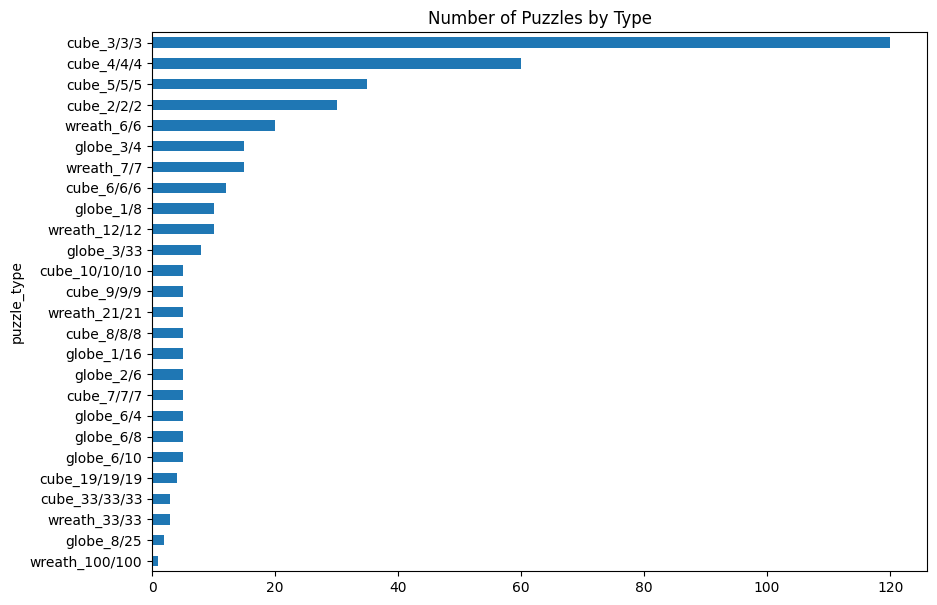

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
puzzles_df['puzzle_type'].value_counts().sort_values().plot(kind='barh', ax=ax)
ax.set_title('Number of Puzzles by Type')
plt.show()

In [7]:
# Nice plot borrowed from https://www.kaggle.com/code/robikscube/santa-2023-polytope-permutation-first-look
puzzles_df.groupby(['puzzle_type'])['num_wildcards'].value_counts() \
    .unstack().fillna(0).astype('int').sort_values(0, ascending=False).style.background_gradient()

num_wildcards,0,2,4,6,8,10,12,16,18,34,38,42,54,176
puzzle_type,,,,,,,,,,,,,,
cube_3/3/3,99,7,9,5,0,0,0,0,0,0,0,0,0,0
cube_4/4/4,50,2,2,1,3,2,0,0,0,0,0,0,0,0
cube_2/2/2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
cube_5/5/5,27,3,0,2,0,2,0,1,0,0,0,0,0,0
wreath_6/6,15,5,0,0,0,0,0,0,0,0,0,0,0,0
wreath_7/7,13,2,0,0,0,0,0,0,0,0,0,0,0,0
globe_3/4,10,4,1,0,0,0,0,0,0,0,0,0,0,0
globe_1/8,9,1,0,0,0,0,0,0,0,0,0,0,0,0
globe_3/33,7,0,0,1,0,0,0,0,0,0,0,0,0,0


In [8]:
reduced_puzzles_df = puzzles_df[['puzzle_type', 'total_components', 'total_unique_components']].drop_duplicates()
reduced_puzzles_df.head(100)

,puzzle_type,total_components,total_unique_components
0,cube_2/2/2,24,6
20,cube_2/2/2,24,24
30,cube_3/3/3,54,6
140,cube_3/3/3,54,54
150,cube_4/4/4,96,6
205,cube_4/4/4,96,96
210,cube_5/5/5,150,6
240,cube_5/5/5,150,150
245,cube_6/6/6,216,6
256,cube_6/6/6,216,216


In [9]:
# Investigating some of these weird numbers
puzzles_df.iloc[205]

id                                                                       205
puzzle_type                                                       cube_4/4/4
solution_state             N0;N1;N2;N3;N4;N5;N6;N7;N8;N9;N10;N11;N12;N13;...
initial_state              N3;N33;N20;N0;N50;N85;N53;N72;N7;N22;N41;N66;N...
num_wildcards                                                              0
initial_state_parsed       [N3, N33, N20, N0, N50, N85, N53, N72, N7, N22...
solution_state_parsed      [N0, N1, N2, N3, N4, N5, N6, N7, N8, N9, N10, ...
total_components                                                          96
unique_components          [N0, N1, N10, N11, N12, N13, N14, N15, N16, N1...
total_unique_components                                                   96
Name: 205, dtype: object

Even within the same puzzle type there are actually different kinds of puzzles!

Not only are the number of wildcards different, there are a few puzzles in there where every piece has to be uniquely placed, not the 'colours' correct. This is repeated for quite a few puzzles. 

In [10]:
puzzle_info_df[['puzzle_type', 'total_allowed_moves']].head(100)

,puzzle_type,total_allowed_moves
0,cube_2/2/2,12
1,cube_3/3/3,18
2,cube_4/4/4,24
3,cube_5/5/5,30
4,cube_6/6/6,36
5,cube_7/7/7,42
6,cube_8/8/8,48
7,cube_9/9/9,54
8,cube_10/10/10,60
9,cube_19/19/19,114


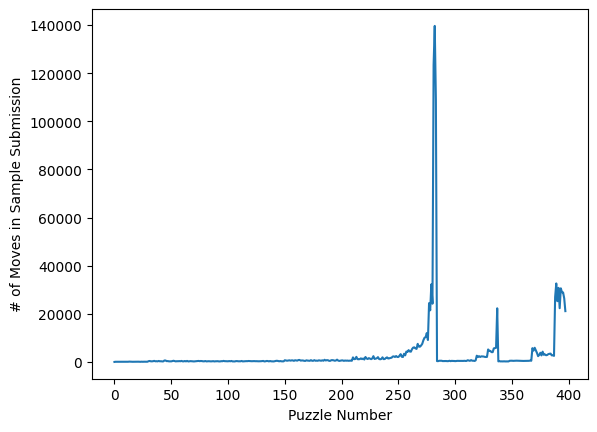

In [11]:
plt.plot(ss_df['total_moves'])
ss_df.sort_values(by='total_moves', ascending=False).head(20)
plt.xlabel("Puzzle Number")
plt.ylabel("# of Moves in Sample Submission")
plt.show()

***
# ⚒️ Operations
Now we try implementing some of the basic operations we expect to need in simulating these puzzles. Specifically we need to:
1. Get the set of possible moves
2. Decide on a move
3. Figure out the state of the puzzle after making the move.

Part 3 is something we really want to get right from the start, so let's build that and test it.

In [12]:
def apply_move(state, move):
    # The move vector tells us what index to sample the next state from
    return [state[i] for i in move]

def test_move_sequence(initial_state, move_sequence, move_dict):
    new_state = initial_state
    print(f"Initial State: {initial_state}")
    for i, move_str in enumerate(move_sequence):
        move = move_dict.get(move_str)
        if move is None:
            print("Requested move is not in puzzle's Move Dictionary")
            return
        new_state = apply_move(new_state, move)
#         print(f"Move #{i}: {move_str}. New state: {new_state}")
    print(f"Final State: {new_state}")

# Test using the sample submission solution for a certain puzzle number
puzzle_number = 1
move_sequence = ss_df.moves_parsed.iloc[puzzle_number]
initial_state = puzzles_df.initial_state_parsed.iloc[puzzle_number]
puzzle_type = puzzles_df.puzzle_type.iloc[puzzle_number]
move_dict = puzzle_info_df.loc[puzzle_info_df['puzzle_type'] == puzzle_type]['allowed_moves_dict'].iloc[0]
test_move_sequence(initial_state, move_sequence, move_dict)

Initial State: ['D', 'E', 'C', 'B', 'B', 'E', 'F', 'A', 'F', 'D', 'B', 'F', 'F', 'E', 'B', 'D', 'A', 'A', 'C', 'D', 'C', 'E', 'A', 'C']
Final State: ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F']


The last line matches the solution so looks like everything's working correctly.

***
# ⭐ A-star Algorithm
This is the algorithm we've chosen to try to decide what move to investigate next.

Here's a great video by Sebatian Lague explaining how the algorithm works for moving along a 2D grid. We're doing the same thing, except the distance from the origin is simply the number of moves, and the distance to the end point is the number of components that are still mismatched. https://www.youtube.com/watch?v=-L-WgKMFuhE&t=110s

The A-star algorithm is widely used for path-finding problems since when properly implemented it can quickly find the optimum solution to get from state A to state B. For solutions with a low number of required moves this will be the best option, but for the bigger problems like the 33x33x33 cube this simply won't work. In these cases we'll just use the answer from the sample submission instead.

Here we've implemented the algorithm with 2 limiting factors: a timeout and maximum depth. This is because for the large puzzles this code could take days to run and still not find a solution. Better to cut it off short.

Deciding the Heuristic (evaluate_score) is very important here. With the A-star algorithm if we choose a heuristic that is 'admissable', it will always find the optimum path. That won't be possible here due to the difficulty in finding such a heuristic and also due to timing constraints. We'll have to settle for an alternative heuristic.

A lot of the solutions I've seen choose a heuristic where you count the number of squares which are different from the final state. This is quite a bad heuristic by itself since every move changes so many squares it jumps around a lot. Here I've tried to improve this by implementing a very basic check for adjacency. We add 1 point for every square that doesn't have a neighbour that's in the same state.

In [ ]:
import heapq

def evaluate_difference(current_state, final_state):
    return (max(0, sum(s != g for s, g in zip(current_state, final_state))))

def evaluate_score(current_state, final_state):
    # Reward having the final position match, and also reward having 2 of the same state adjacent to each other
    # This has to be fast since it's called so often
    return (max(0, sum(s != g for s, g in zip(current_state, final_state))) + sum(s != g for s, g in zip(current_state[1:], current_state[:-1])) + 0.5*sum(s != g for s, g in zip(current_state[2:], current_state[:-2])))


def astar(move_dict, initial_state, final_state, wildcards, max_depth=50, timeout = 180):
    # Priority queue to store nodes with their f-values (g + h)
    start_time = time.time()
    open_set = []
    node_counter = 1
    
    heapq.heappush(open_set, (0, initial_state, []))  # (priority, state, path, remaining wildcards)
    # Set to keep track of visited nodes
    closed_set = set()

    while open_set:
        # Check for timeout
        if time.time() - start_time > timeout:
            print("Timed out.")
            return None, node_counter
        
        # Get the node with the lowest f-value
        current_f, current_state, current_path = heapq.heappop(open_set)
        
        if len(current_path) > max_depth:
            print("Max depth exceeded.")
            return None, node_counter

        if evaluate_difference(current_state, final_state) <= wildcards:
            # We've achieved our goal. Return the move path.
            return current_path, node_counter

        closed_set.add(tuple(current_state))
        
        for move_str, move in move_dict.items():
            new_state = apply_move(current_state, move)
            if tuple(new_state) not in closed_set:
                if len(current_path) < max_depth:
                    heapq.heappush(open_set, (len(current_path) + 1 + evaluate_score(new_state, final_state), new_state, current_path + [move_str]))
                    node_counter += 1
    # If no solutions are found:
    print("Open set completed. No solutions.")
    return None, node_counter

def plot_final_path(move_dict, initial_state, final_state, path):
    state_list = [initial_state]
    for move in path:
        state_list.append(apply_move(state_list[-1], move_dict[move]))
    eval_list = [evaluate_score(state, final_state) for state in state_list]
    plt.plot(eval_list)
    plt.xlabel("Move Number")
    plt.ylabel("Heuristic Score")
    plt.show()
    

I've added a plotting function (plot_final_path to see how our heuristic score changes as we progress through our solution. This is a good way to check whether our algorithm is working well. We expect this graph to *gradually* progress from the score at the initial state to the final state.

There are two separate functions, evaluating our heuristic (evaluate_score) and also evaluating whether we have reached a 'solved' state (evaluate_difference).

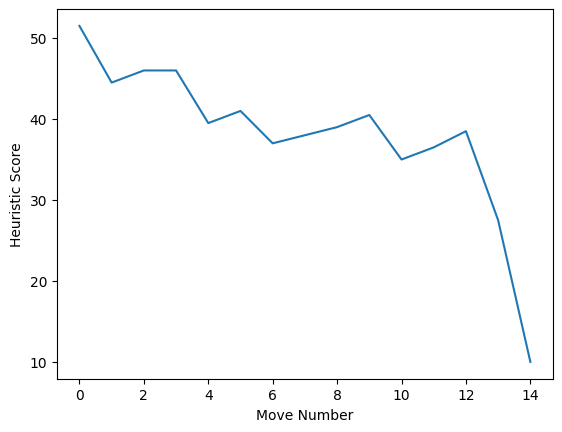

Testing - Puzzle #4 solved in 14 moves. 106131 nodes. 0 wildcards. ['r0', '-f0', 'r1', '-f1', 'd0', 'r0', 'r0', '-f0', '-r0', 'f0', 'r0', '-f0', '-r0', 'f0'].


In [14]:
# Test using the sample submission solution for a certain puzzle number
puzzle_number = 4
move_sequence = ss_df.moves_parsed.iloc[puzzle_number]
initial_state = puzzles_df.initial_state_parsed.iloc[puzzle_number]
final_state = puzzles_df.solution_state_parsed.iloc[puzzle_number]
puzzle_type = puzzles_df.puzzle_type.iloc[puzzle_number]
wildcards = puzzles_df.num_wildcards.iloc[puzzle_number]
move_dict = puzzle_info_df.loc[puzzle_info_df['puzzle_type'] == puzzle_type]['allowed_moves_dict'].iloc[0]

solution_path, node_counter = astar(move_dict, initial_state, final_state, wildcards)
plot_final_path(move_dict, initial_state, final_state, solution_path)

print(f"Testing - Puzzle #{puzzle_number} solved in {len(solution_path)} moves. {node_counter} nodes. {wildcards} wildcards. {solution_path}.")

In [15]:
# Puzzle solver automated
def solve_puzzles(puzzles_df, puzzle_info_df):
    solution_list = []
    for puzzle_number in np.arange(len(puzzles_df)):
        puzzle_start_time = time.time()
        solution_dict = {'id': puzzle_number}
        ss_moves = len(ss_df[ss_df['id'] == puzzle_number]['moves'].iloc[0])
        solution_path = None
        node_counter = 0
        if ss_moves < 1500:
            # Only try to solve the smaller puzzles, otherwise skip it to save time.
            move_sequence = ss_df.moves_parsed.iloc[puzzle_number]
            initial_state = puzzles_df.initial_state_parsed.iloc[puzzle_number]
            final_state = puzzles_df.solution_state_parsed.iloc[puzzle_number]
            puzzle_type = puzzles_df.puzzle_type.iloc[puzzle_number]
            wildcards = puzzles_df.num_wildcards.iloc[puzzle_number]
            move_dict = puzzle_info_df.loc[puzzle_info_df['puzzle_type'] == puzzle_type]['allowed_moves_dict'].iloc[0]

            solution_path, node_counter = astar(move_dict, initial_state, final_state, wildcards, max_depth = ss_moves)
        if solution_path is not None:
            solution_moves = ".".join(solution_path)
            self_solved = True
            print(f"Puzzle #{puzzle_number} solved in {len(solution_path)} moves. {(time.time()-puzzle_start_time):.2f} seconds, {node_counter} nodes. {solution_path}")
        else:
            # If no solution found, use the sample submission's result
            solution_moves = ss_df[ss_df['id'] == puzzle_number]['moves'].iloc[0]
            solution_path = ss_df[ss_df['id'] == puzzle_number]['moves_parsed'].iloc[0]
            self_solved = False
            print(f"Puzzle #{puzzle_number} failed after {(time.time()-puzzle_start_time):.2f} seconds, {node_counter} nodes. Using sample submission solution instead.")
        solution_dict = {
            'id': puzzle_number,
            'moves': solution_moves,
            'move_total': len(solution_path),
            'ss_moves': ss_moves,
            'self_solved': self_solved,
            'time_taken': time.time()-puzzle_start_time,
            'node_counter': node_counter,
        }
        solution_list.append(solution_dict)
    solution_df = pd.DataFrame(solution_list)
    return solution_df

solution_df = solve_puzzles(puzzles_df, puzzle_info_df)
solution_df.head(400)

Puzzle #0 solved in 2 moves. 0.00 seconds, 24 nodes. ['r1', '-f1']
Puzzle #1 solved in 13 moves. 1.03 seconds, 38359 nodes. ['f1', '-d0', '-r0', 'f1', 'r0', 'f0', 'd1', '-r0', '-d0', 'f0', 'f0', 'd0', '-f0']
Puzzle #2 solved in 14 moves. 2.59 seconds, 92753 nodes. ['-f1', 'f0', '-r1', '-r1', '-f0', '-r0', '-d0', '-f0', 'd0', 'f0', 'f0', '-d0', '-f0', 'd0']
Puzzle #3 solved in 14 moves. 5.02 seconds, 176509 nodes. ['-f0', '-d0', '-f1', 'r0', '-d1', 'r0', 'f1', '-r1', '-d1', 'r1', '-f0', 'r1', 'f0', '-d1']
Puzzle #4 solved in 14 moves. 2.80 seconds, 106131 nodes. ['r0', '-f0', 'r1', '-f1', 'd0', 'r0', 'r0', '-f0', '-r0', 'f0', 'r0', '-f0', '-r0', 'f0']
Puzzle #5 solved in 12 moves. 2.95 seconds, 105516 nodes. ['-d1', '-r0', '-r0', 'f0', 'd1', 'r1', '-f1', '-r1', 'f0', '-d1', '-d1', '-f0']
Puzzle #6 solved in 14 moves. 2.54 seconds, 90840 nodes. ['-r0', '-d1', 'r1', '-f0', '-d1', '-f0', 'r1', '-f1', '-d1', '-r0', '-f0', '-d0', 'f0', 'd0']
Puzzle #7 solved in 13 moves. 5.82 seconds, 206673

,id,moves,move_total,ss_moves,self_solved,time_taken,node_counter
0,0,r1.-f1,2,6,True,0.002493,24
1,1,f1.-d0.-r0.f1.r0.f0.d1.-r0.-d0.f0.f0.d0.-f0,13,227,True,1.033380,38359
2,2,-f1.f0.-r1.-r1.-f0.-r0.-d0.-f0.d0.f0.f0.-d0.-f...,14,227,True,2.591525,92753
3,3,-f0.-d0.-f1.r0.-d1.r0.f1.-r1.-d1.r1.-f0.r1.f0.-d1,14,341,True,5.024981,176509
4,4,r0.-f0.r1.-f1.d0.r0.r0.-f0.-r0.f0.r0.-f0.-r0.f0,14,252,True,2.799824,106131
...,...,...,...,...,...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...,30596,129256,False,0.001504,0
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...,28971,122720,False,0.001608,0
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....,28876,122608,False,0.001503,0
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...,26402,108876,False,0.001466,0


In [16]:
# Look over solution
print(f"Total moves: {solution_df['move_total'].sum()}")
print(f"Total sample solution moves: {solution_df['ss_moves'].sum()}")
print(f"Improvement compared to sample solutions: {100-100*solution_df['move_total'].sum()/solution_df['ss_moves'].sum():.2f}%")
print(f"Total solved: {solution_df['self_solved'].sum()}")
print(f"Total time taken: {solution_df['time_taken'].sum()/60:.2f} minutes")

Total moves: 1204168
Total sample solution moves: 4701608
Improvement compared to sample solutions: 74.39%
Total solved: 68
Total time taken: 384.38 minutes


***
# 📮 Final Submission
Now we just need to convert this dict into a csv matching the sample submission and we're off!
Thanks for following along, comment any questions you have and I'll try to answer!

🎅 Merry christmas and happy new year! 🎅

In [17]:
# Compile into csv
final_solution_df = solution_df[['id', 'moves']]
final_solution_df.to_csv("submission.csv", header=['id', 'moves'], index=False)
print(final_solution_df)

      id                                              moves
0      0                                             r1.-f1
1      1        f1.-d0.-r0.f1.r0.f0.d1.-r0.-d0.f0.f0.d0.-f0
2      2  -f1.f0.-r1.-r1.-f0.-r0.-d0.-f0.d0.f0.f0.-d0.-f...
3      3  -f0.-d0.-f1.r0.-d1.r0.f1.-r1.-d1.r1.-f0.r1.f0.-d1
4      4    r0.-f0.r1.-f1.d0.r0.r0.-f0.-r0.f0.r0.-f0.-r0.f0
..   ...                                                ...
393  393  f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394  394  -f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395  395  -r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396  396  f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...
397  397  -r1.f23.-f24.-r2.f30.f30.f38.-f19.f24.f19.f18....

[398 rows x 2 columns]
